In [1]:
#Imports

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Create the test set using the same seed used in the training to avoid overlapping of samples
def get_training_set(path):
    data_path = path+"balanced_binary_classification_dataset.csv"
    df = pd.read_csv(data_path)

    texts = df['text'].tolist()
    labels = df['label'].tolist()

    #split the data in 70%,15%,15% for training, evaluation and testing
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.3, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels  = train_test_split(
        val_texts, val_labels, test_size=0.5, random_state=42
    )
    return test_texts,test_labels

In [3]:
# Handles the display in case of testing with custom input sentences
def print_custom_results(sentences, probabilities):
    for i, sentence in enumerate(sentences):
      probs = probabilities[i]
      predicted_class = torch.argmax(probs).item()
      print(f"Input: {sentence}")
      print(f"  Toxic Probability: {probs[1]:.4f}")
      print(f"  Not Toxic Probability: {probs[0]:.4f}")
      print(f"  Prediction: {'Toxic' if predicted_class == 1 else 'Not Toxic'}\n")

In [4]:
#Print general statistics on the test executed with the testing set
def print_stats(labels, predictions):
  accuracy = accuracy_score(labels, predictions)
  f1 = f1_score(labels, predictions)
  precision = precision_score(labels, predictions)
  recall = recall_score(labels, predictions)

  print(f"Accuracy: {accuracy:.2f}")
  print(f"F1 Score: {f1:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")

  # Confusion Matrix
  conf_matrix = confusion_matrix(labels, predictions)

  # Plot Confusion Matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

In [5]:
# Handles big test sets in batch to avoid saturating the available RAM
def predict_in_batches(sentences, labels, model, tokenizer, batch_size=16):
    predictions = []
    true_labels = []

    # Process data in batches
    for i in range(0, len(sentences), batch_size):
      batch_sentences = sentences[i:i+batch_size]
      batch_labels = labels[i:i+batch_size]

      # Tokenize the batch
      inputs = tokenizer(
          batch_sentences,
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=128
      )

      # Perform the prediction
      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits
          probabilities = F.softmax(logits, dim=-1)
          batch_predictions = torch.argmax(probabilities, dim=-1).numpy()

      # Append the prediction of each batch to have a unique one
      predictions.extend(batch_predictions)
      true_labels.extend(batch_labels)

    return np.array(predictions), np.array(true_labels)

In [6]:
# Base function to run tests
def test(path, custom=False, sentences=None):
  # Load a model
  model_dir = path+"model_save"
  model = AutoModelForSequenceClassification.from_pretrained(model_dir)
  tokenizer = AutoTokenizer.from_pretrained(model_dir)

  # if we are not evaluating on custom sentences we recover the testing set
  if not custom:
    sentences,labels = get_training_set(path)

  # if the testing set doesn not contain a lot of samples we tokenize the whole input
  if len(sentences) < 200:
    model.eval()

    inputs = tokenizer(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1).numpy()

  # otherwise we split the input in batches
  else:
    print(len(sentences))
    predictions, labels = predict_in_batches(sentences, labels, model, tokenizer, batch_size=16)

  # call the corresponding function to visualize the results of the testing
  if custom:
    print_custom_results(sentences, probabilities)
  else:
    print_stats(labels, predictions)


8984
Accuracy: 0.90
F1 Score: 0.90
Precision: 0.87
Recall: 0.93


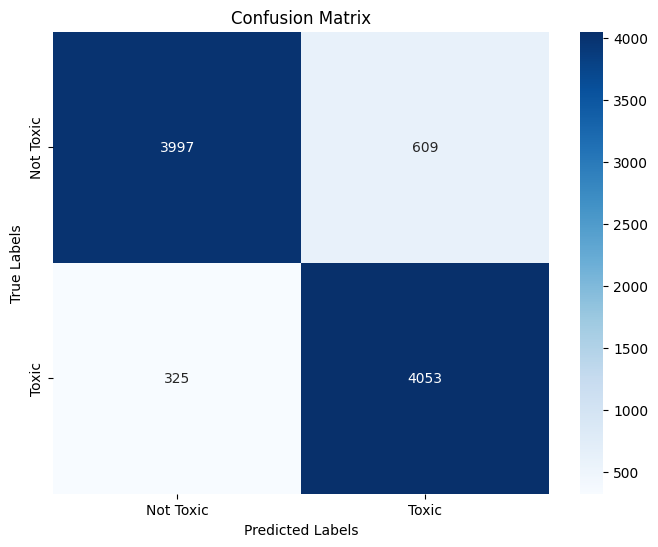

In [8]:
def main():
  test(path="/content/drive/My Drive/Projet IA/")
  custom_sentences = [
    "You're son of a bitch and I will puch you if you don't stop",
    "I want to kill myself tonight",
    "I want to punch you, your bitch!",
    "Thank you for helping me out, you're so kind.",
    "you're useless and not worth a single penny, you should leave the company immediately!!!",
    "I think you could improve your product because as of now is not good, but there's still margin",
    "I will punch you if you don't stop kidding on me",
    "you too motherfucker, i was joking",
    "you know i like to joke around like a son of a bitch",
    "you are a son of a beach"
  ]
  #test(path="", custom=True, sentences=custom_sentences)
if __name__ == "__main__":
    main()